## ME 592X: Data Analytics and Machine Learning for Cyber-Physical Systems

##### Homework 3  Mohammad Rashid Mohammad Shoaib, Jacob Bergfeld, Melika Tajipour     4/11/2023

### Engineering Image Analysis - Convolutional Neural Newtwork

In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torchvision.transforms import transforms
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import scipy.io
from matplotlib.pyplot import imshow
%matplotlib inline
import cv2
import os

In [2]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:
# Loding the data file as read only file and assigning it as numpy array. 
filename = 'combustion_img_13.mat'
with h5py.File(filename, 'r') as f:
    x_train = np.array(f['train_set_x'])
    y_train = np.array(f['train_set_y'])
    x_val = np.array(f['valid_set_x'])
    y_val = np.array(f['valid_set_y'])
    x_test = np.array(f['test_set_x'])
    y_test = np.array(f['test_set_y'])

In [5]:
# Saving some images for inspection and visualization
save_path = 'C:\\Users\\mbshoa\\OneDrive - Emerson\\Desktop\\ME 592\\combustion'

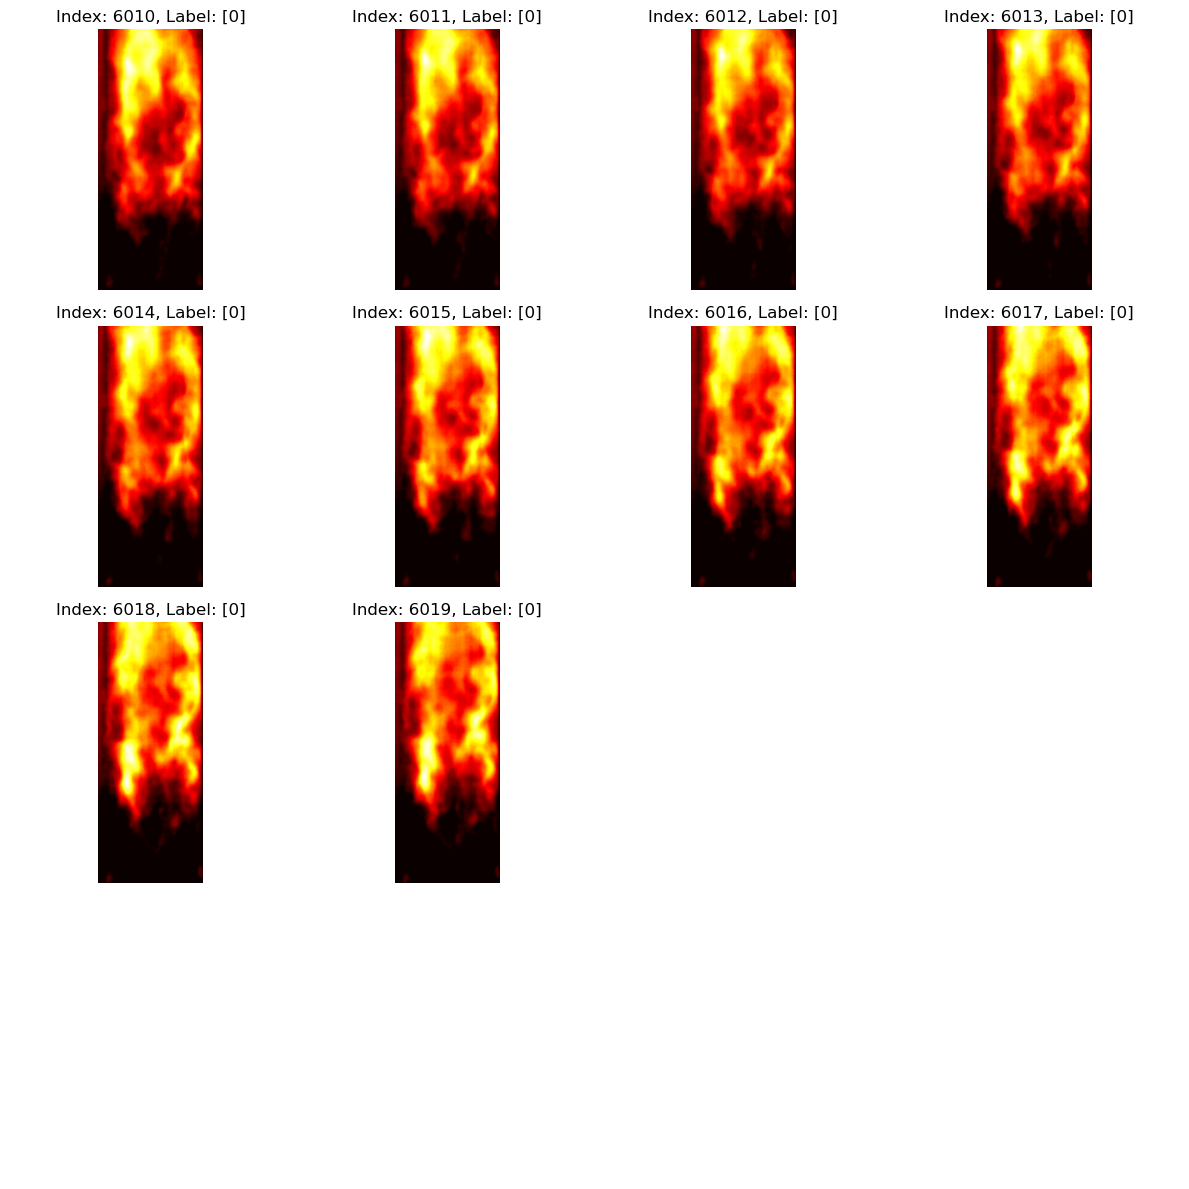

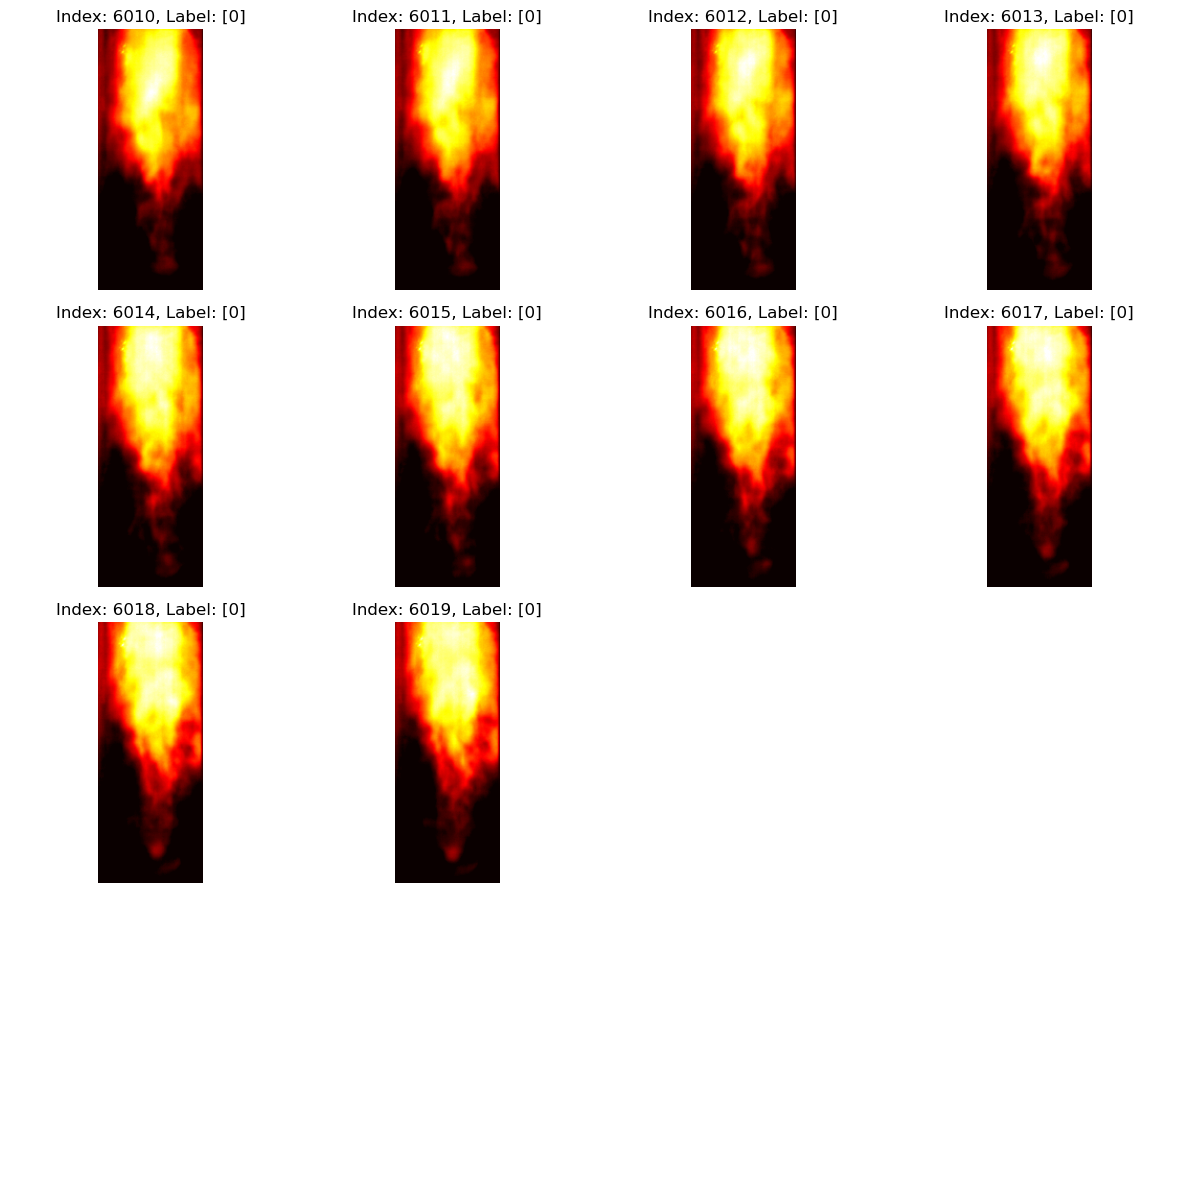

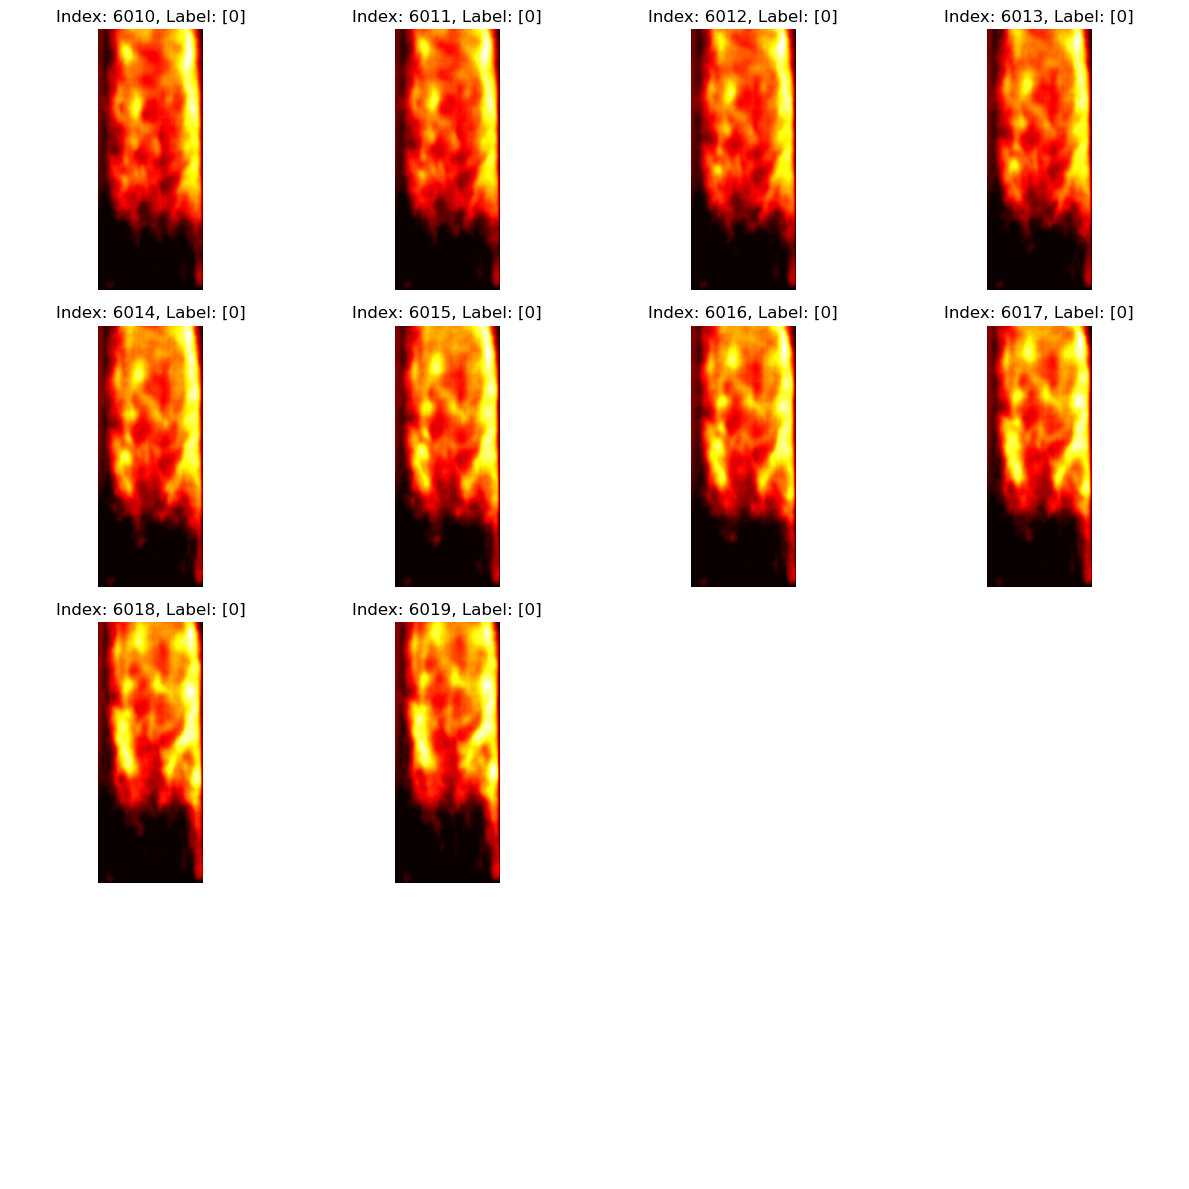

In [6]:
def save_images(data, labels, folder_name, start_index, end_index, plot_grid=True):
    folder_path = os.path.join(save_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)

    # Transpose labels if needed
    if labels.shape[0] == 1:
        labels = labels.T

    num_images = end_index - start_index
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    idx = 0
    for i in range(start_index, end_index):
        img = data[:, i].reshape(250, 100)
        label = labels[i]

        img_path = os.path.join(folder_path, f"img_{i}_label_{label}.png")
        cv2.imwrite(img_path, img)

        if plot_grid:
            row, col = idx // grid_size, idx % grid_size
            axs[row, col].imshow(img, cmap='hot')
            axs[row, col].set_title(f"Index: {i}, Label: {label}")
            axs[row, col].axis('off')
            idx += 1

    if plot_grid:
        for i in range(idx, grid_size * grid_size):
            row, col = i // grid_size, i % grid_size
            axs[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
index_start = 6010
index_end = 6020
save_images(x_train, y_train, 'train', start_index=index_start, end_index=index_end)
save_images(x_test, y_test, 'test', start_index=index_start, end_index=index_end)
save_images(x_val, y_val, 'val', start_index=index_start, end_index=index_end)

In [7]:
# Normalizing the pixel values to the range [0, 1]; also converting data to float32 type for division operation
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_val = x_val.astype(np.float32) / 255.0

In [8]:
# Reshaping images from 1D to 4D array (#images, height, width, #channels) and transposing the data into (batch_size, channels, height , width)
x_train = np.transpose(x_train.reshape(-1, 250, 100, 1), (0, 3, 1, 2))
x_test = np.transpose(x_test.reshape(-1, 250, 100, 1), (0, 3, 1, 2))
x_val = np.transpose(x_val.reshape(-1, 250, 100, 1), (0, 3, 1, 2))

In [10]:
# Encoding the labels 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [11]:
# Converting data to PyTorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

In [12]:
# Creating PyTorch datasets
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
val_dataset = TensorDataset(x_val, y_val)

In [13]:
#Hyper parameters
batch_size = 320
num_epochs = 25
learning_rate = 3e-4

In [14]:
# Creating PyTorch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
   
    #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (N, 1, 250, 100)
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (N, 1, 250, 100)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (N, 12, 250, 100)
        self.relu1=nn.ReLU()
        #Shape= (N, 12, 250, 100)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (N, 12, 125, 50)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (N, 12, 125, 50)
        self.relu2=nn.ReLU()
        #Shape= (N, 20, 125, 50)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (N, 32, 125, 50)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (N, 32, 125, 50)
        self.relu3=nn.ReLU()
        #Shape= (N, 32, 125, 50)
        
        
        self.fc=nn.Linear(in_features=125 * 50 * 32,out_features=num_classes)
        
        
        
        #forward pass
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (N, 32, 125, 50)
            
        output=output.view(-1,32*125*50)
                        
        output=self.fc(output)
            
        return output

In [16]:
model = ConvNet()
optimizer=Adam(model.parameters(),lr=learning_rate,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [17]:
train_count = len(train_dataset)
test_count = len(test_dataset)

In [ ]:
print('Hyperparameters')
print('batch_size = ',batch_size)
print('num_epochs = ', num_epochs)
print('learning_rate = ', learning_rate)

#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.4f} Test Acc: {test_accuracy:.4f}")
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

### Results and Discussion 

Below are the results of each run with different values of hyperprarameters. We selected 3 hyperparameters to tune in - Bactch size, number of epochs and learning rate. 

<b>Run 1:</b> For run 1, we aimed to verify that our code was functioning properly, so we trained the model for only 5 epochs. We observed that the loss function value decreased, which is a positive indication, and the training accuracy was quite high. The decreasing loss function value indicates that model is learning and improving and the high training accurary indicates that the model was able to learn the patterns in the training data. However, the test accuracy was not satisfactory, with the highest recorded value being only 46%. 
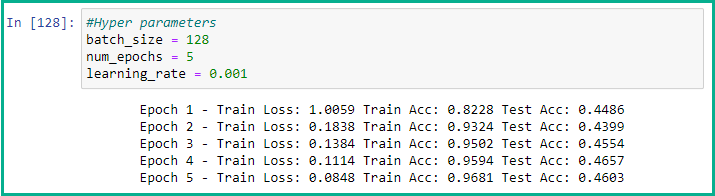

_______________________________________________________________________________

<b>Run 2:</b> For run 2, we increased the batch size and number of epochs while keeping the same learning rate as in run 1. Despite observing a decrease in the loss function and high training accuracy, the test accuracy did not improve and actually decreased, which is not desirable. 
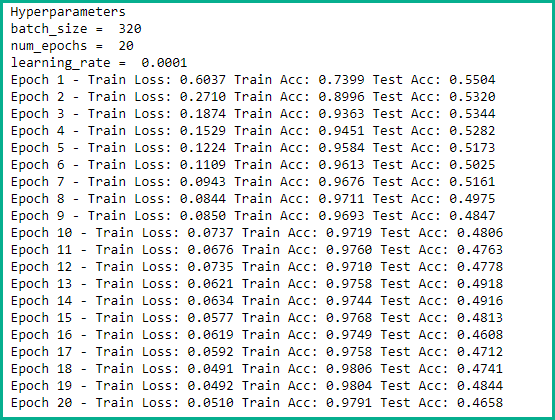

_______________________________________________________________________________

<b>Run 3:</b> For run 3, we maintained the same number of epochs and batch size as in run 2 but changed the learning rate from 0.0001 to 0.0003. Upon comparing the results to those of run 2, we observed a decrease in test accuracy, with the highest recorded test accuracy value dropping from 55% to 52%.
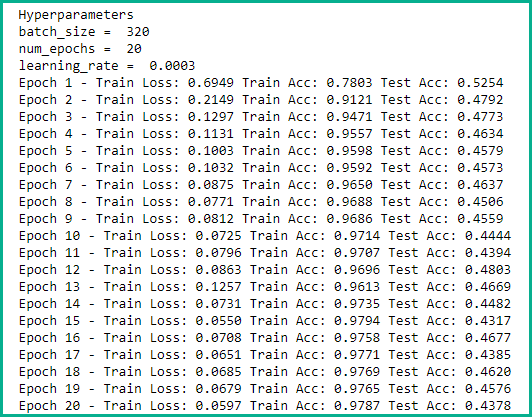

_______________________________________________________________________________

<b>Run 4:</b> For run 4, we updated the number of epochs to 20 and batch size to 500 while keeping the learning rate same. In this run we observed the lowest value of loss function compared to all runs so far and also the highest test accuraty of 57%
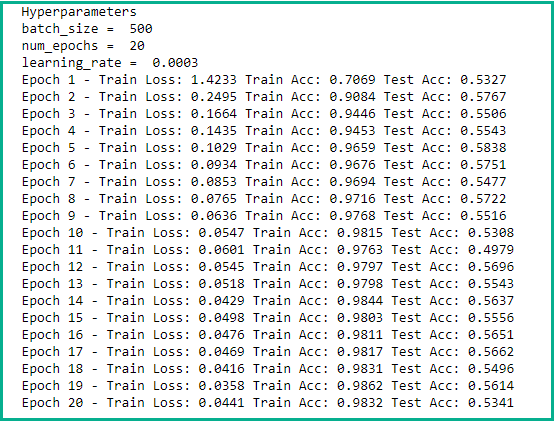

_______________________________________________________________________________

<b>Run 5:</b> For run 5, we decreased the batch size and increased the number of epochs while maintaining the same learning rate. We observed that the results were quite similar to those of run 4, but interestingly, as the number of iterations increased, the test accuracy decreased.
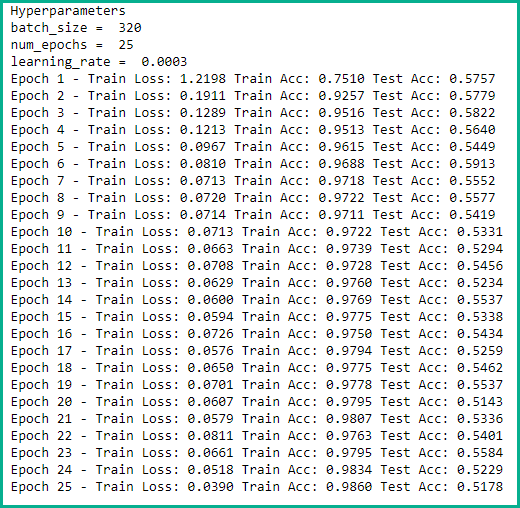

_______________________________________________________________________________

Overall, after running the code 5 times trying to find an optimal combination of batch size, number of epochs, and learning rate to achieve the best model performance. We concluded that run 4 combination produced the best results, with the lowest loss function value and high test accuracy.


### Challenges & Learning

- One of the biggest challenges we faced during this project was reading the data accurately and ensuring that the tensor sizes were matched correctly. We initially attempted to use custom datasets classes, but encountered tensor size errors and instead had to rely on step-by-step data processing

- We also gained an understanding of how to calculate the output shape of the tensor after each neural network layer, but encountered issues when reducing the image size. For example, after applying a Max Pooling layer, the image size was reduced from 250 x 100 to 125 x 50. However, we faced challenges when attempting to reduce the dimensions further, such as running into decimal values which we believe contributed to some of the errors encountered. 

- Additionally, we had difficulty running CUDA on JetStream2 and encountered errors when attempting to do so. As a result, all the reported results were obtained using the CPU on a local machine, which took several hours to complete.

- Despite these challenges, we found this project to be enjoyable and informative, and gained valuable hands-on experience with Python and training convolutional neural networks